# TP Inteligencia Artifial

Se busca realizar una red neuronal convulsional que detecte a partir de una radiografía de torax si el paciente tiene o no neumonía.

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import scipy
import skimage
from skimage.transform import resize
import PIL

# Levantamos los archivos que pertenecen al dataset

In [2]:
dirname = os.path.join(os.getcwd(), 'chest_xray\dataset')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            image_resized = resize(image, (256, 256,1),anti_aliasing=True,clip=False,preserve_range=True)
            images.append(image_resized)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\User\Documents\Tp-InteligenciaArtificial\chest_xray\dataset\
C:\Users\User\Documents\Tp-InteligenciaArtificial\chest_xray\dataset\neumonia 1
C:\Users\User\Documents\Tp-InteligenciaArtificial\chest_xray\dataset\normal 4265
Directorios leidos: 2
Imagenes en cada directorio [4266, 1574]
suma Total de imagenes en subdirs: 5840


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  5840


In [4]:
placas = []
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    placas.append(name[len(name)-1])
    indice=indice+1

0 neumonia
1 normal


In [6]:
y = np.array(labels)
X = np.array(images) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (4672, 256, 256, 1) (4672,)
Testing data shape :  (1168, 256, 256, 1) (1168,)


Text(0.5, 1.0, 'Ground Truth : 1')

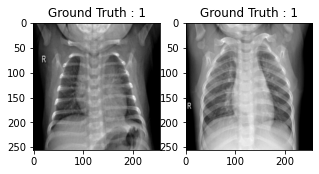

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Encodeamos las labels a one-hot encoding

In [9]:

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [10]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

# Generamos la red neuronal convulsional

In [11]:

#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [13]:
neumonia_model = Sequential()
neumonia_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(256,256,1)))
neumonia_model.add(LeakyReLU(alpha=0.1))
neumonia_model.add(MaxPooling2D((2, 2),padding='same'))
neumonia_model.add(Dropout(0.5))

neumonia_model.add(Flatten())
neumonia_model.add(Dense(32, activation='linear'))
neumonia_model.add(LeakyReLU(alpha=0.1))
neumonia_model.add(Dropout(0.5))
neumonia_model.add(Dense(nClasses, activation='softmax'))
neumonia_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16777248  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)               

In [14]:
neumonia_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

In [15]:
neumonia_train = neumonia_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/6
59/59 [==============================] - 149s 3s/step - loss: 393.9966 - accuracy: 0.6524 - val_loss: 7.4868 - val_accuracy: 0.9080
Epoch 2/6
59/59 [==============================] - 124s 2s/step - loss: 38.1344 - accuracy: 0.8006 - val_loss: 13.7304 - val_accuracy: 0.8877
Epoch 3/6
59/59 [==============================] - 103s 2s/step - loss: 28.4885 - accuracy: 0.8218 - val_loss: 6.1595 - val_accuracy: 0.9230
Epoch 4/6
59/59 [==============================] - 79s 1s/step - loss: 16.4033 - accuracy: 0.8630 - val_loss: 7.7349 - val_accuracy: 0.8984
Epoch 5/6
59/59 [==============================] - 80s 1s/step - loss: 19.2370 - accuracy: 0.8459 - val_loss: 6.5210 - val_accuracy: 0.9369
Epoch 6/6
59/59 [==============================] - 83s 1s/step - loss: 11.4482 - accuracy: 0.8780 - val_loss: 7.6133 - val_accuracy: 0.9348


In [16]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
neumonia_model.save("neumonia_cnn.h5py")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: neumonia_cnn.h5py\assets


# Evaluamos la red neuronal

In [17]:
test_eval = neumonia_model.evaluate(test_X, test_Y_one_hot, verbose=1)

37/37 [==============================] - 6s 156ms/step - loss: 8.7897 - accuracy: 0.9255


In [18]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 8.789718627929688
Test accuracy: 0.9255136847496033


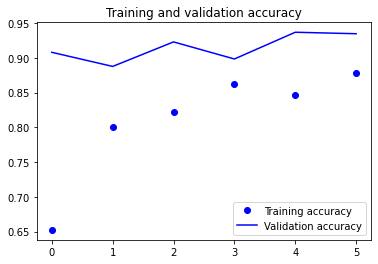

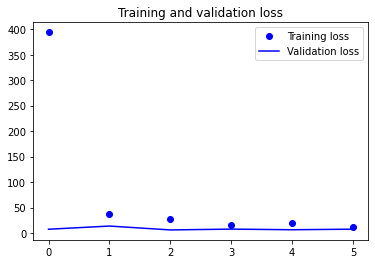

In [21]:
accuracy = neumonia_train.history['accuracy']
val_accuracy = neumonia_train.history['val_accuracy']
loss = neumonia_train.history['loss']
val_loss = neumonia_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Predicción de una imagen nueva

In [41]:
images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['chest_xray/val/normal/NORMAL2-IM-1438-0001.jpeg','chest_xray/val/neumonia/person1954_bacteria_4886.jpeg']

for filepath in filenames:
    dirname = os.path.join(os.getcwd(), filepath)
    image = plt.imread(dirname,0)
    image_resized = resize(image, (256, 256,1),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images) #convierto de lista a numpy

predicted_classes = neumonia_model.predict(test_X)
for i in range(0, len(filenames)):
    prediction = predicted_classes[i]
    print(filenames[i], placas[prediction.tolist().index(max(prediction))])

chest_xray/val/normal/NORMAL2-IM-1438-0001.jpeg normal
chest_xray/val/neumonia/person1954_bacteria_4886.jpeg neumonia
